# In this Jupyter notebook we will look at the associations between MLPs and other measured phenotypes in the wild isolates gathered by Jeffares et al. 2015

In [1]:
#importing standard data science libraries
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import scipy.stats as st
%matplotlib inline  
root = "/Users/bencekover/Library/CloudStorage/OneDrive-UniversityCollegeLondon/MSci Bahler lab/S.-Pombe-MLPs/"




data = pd.read_excel(root + 'external data/Jeffares et al. 2015,2017/Jeffares 2015 measurements and LTRs.xlsx', sheet_name=4, header=16)
strain_clusters = pd.read_excel(root + 'external data/Jeffares et al. 2015,2017/Jeffares 2015 measurements and LTRs.xlsx', sheet_name=1, header=4)
liv_data = pd.read_csv(root + 'internal data/Liv_data_mean.csv')



#strain_clusters retain strain name and MCL cluster members without last 4 rows
strain_clusters = strain_clusters[['strain name', 'MCL cluster','substrate','date collected']]
strain_clusters = strain_clusters.iloc[:-4]

#washing data 
washing_emm = pd.read_csv(root + 'Bence folder/Phenotypes/phenotype_gwas.csv')
washing_yes = pd.read_csv(root + 'Bence folder/Phenotypes/phenotype_yes_gwas.csv')
#in washing_emm rename ratio to Washing (EMM)
washing_emm = washing_emm.rename(columns={'ratio':'Washing (EMM)'})
#keep only strain and Washing (EMM) columns
washing_emm = washing_emm[['strain', 'Washing (EMM)']]
#in washing_yes rename ratio to Washing (yes)
washing_yes = washing_yes.rename(columns={'ratio':'Washing (YES)'})
#keep only strain and Washing (yes) columns
washing_yes = washing_yes[['strain', 'Washing (YES)']]

#high-thropughput floc data /Users/bencekover/Library/CloudStorage/OneDrive-UniversityCollegeLondon/MSci Bahler lab/S.-Pombe-biofilm/Bence folder/Phenotypes/plate_reader_wild_isolates_results.csv
floc_data_emm =  pd.read_csv(root + 'Bence folder/Phenotypes/plate_reader_wild_isolates_results.csv')
#rename Mean to Floc (EMM)
floc_data_emm = floc_data_emm.rename(columns={'Mean':'Floc (EMM)'})
#add strain clusters to data using strain name column in strain_clusters and strain column in data
data = data.merge(strain_clusters, left_on='strain', right_on='strain name', how='left')


#add it to data based on column strain
data = data.merge(washing_emm, on='strain', how='left')
data = data.merge(washing_yes, on='strain', how='left')
data = data.merge(floc_data_emm, left_on='strain', right_on='Strain', how='left')
data = data.merge(liv_data, left_on='strain', right_on='Sample', how='left')
#remove useless columns: strain name, Strain, SEM, Unnamed: 0
data = data.drop(columns=['strain name', 'Strain', 'SEM', 'Unnamed: 0','Sample'])

#for columns where there is smgrowth in the name, take log2
for col in data.columns:
    if 'smgrowth' in col:
        data[col] = np.log2(data[col])


#create column "sticky_yes_binary" which is 1 if Washing (YES) > 0.2
data["sticky_yes_binary"] = [1 if x>


/Users/bencekover/opt/anaconda3/lib/python3.9/site-packages/openpyxl/worksheet/_read_only.py:79: UserWarning: Unknown extension is not supported and will be removed
  for idx, row in parser.parse():
/Users/bencekover/opt/anaconda3/lib/python3.9/site-packages/openpyxl/worksheet/_read_only.py:79: UserWarning: Unknown extension is not supported and will be removed
  for idx, row in parser.parse():
/Users/bencekover/opt/anaconda3/lib/python3.9/site-packages/pandas/core/arraylike.py:397: RuntimeWarning: divide by zero encountered in log2
  result = getattr(ufunc, method)(*inputs, **kwargs)


In [3]:
#imputing MLP data for all strains of the same cluster
#iterate through rows of data
for index, row in data.iterrows():
      completed_clusters = []
    #check whether MCL cluster is NaN. If not keep going
      if pd.notnull(row['MCL cluster']) and row['MCL cluster'] not in completed_clusters:
            if pd.notnull(row['Washing (EMM)']):
                #find indices of all rows in the same cluster
                  cluster_indices = data[data['MCL cluster']==row['MCL cluster']].index
                  #assign the same 'Washing (EMM)' value to all rows in the same cluster
                  data.loc[cluster_indices, 'Washing (EMM)'] = row['Washing (EMM)']
                  #and 'Washing (YES)'
                  data.loc[cluster_indices, 'Washing (YES)'] = row['Washing (YES)']
                  #and 'Floc (EMM)'
                  data.loc[cluster_indices, 'Floc (EMM)'] = row['Floc (EMM)']
                  #add cluster to completed clusters
                  completed_clusters.append(row['MCL cluster'])
#remove MCL cluster column

data = data.rename(columns={'Lifespan':'Chronological Lifespan (YES)'})
#change washing to Adhesion to agar (YES)
data = data.rename(columns={'Washing (YES)':'Adhesion to agar (YES)'})

In [4]:

#cretae a function that takes data as input, and a column name, and returns the correlation coefficient pearson and spearman and p values
def correlation(data, column):
    results_df = pd.DataFrame(columns=['Pearson', 'Spearman', 'Pearson p-value', 'Spearman p-value','T_test','ANOVA_pvalue','phenotype'])
    for i in data.columns:
    #if i is not the column we are interested in and not string
        if i != column and data[i].dtype != 'O':
        #create subset of the data that is only the column and i
            subset = data[[column, i]]
            #drop inf
            subset = subset.replace([np.inf, -np.inf], np.nan)
            #remove nans
            subset = subset.dropna()
            
            #if column is string or 1/0 are the only unique values and i has more than 2 unique values
            if  len(subset[column].unique()) == 2:
                #do t-test
                T = st.ttest_ind(subset[column], subset[i],permutations=10000)
                results_df.loc[i] = [np.nan, np.nan, np.nan, np.nan, T[1], np.nan, i]
            elif data[column].dtype == 'O' and len(subset[column].unique()) > 2:
                #do anova
                for g in subset[column].unique():
                    if len(subset[subset[column]==g]) == 1:
                        subset = subset[subset[column]!=g]
                #create a list of lists
                
                subset = subset.groupby(column)[i].apply(list).reset_index(name='list')
                anova = st.f_oneway(*subset['list'])
                
            
                results_df.loc[i] = [np.nan, np.nan, np.nan, np.nan, np.nan, anova[1], i]
            else:
                #do pearson and spearman
                pearson = st.pearsonr(subset[column], subset[i])
                spearman = st.spearmanr(subset[column], subset[i])
                results_df.loc[i] = [pearson[0], spearman[0], pearson[1], spearman[1], np.nan, np.nan, i]
    return results_df
corrs = correlation(data,"Adhesion to agar (YES)")
corrs = corrs.sort_values(by=['Spearman p-value'])
#corrs remove nan from spearman and then create column called fdr
corrs = corrs.dropna(subset=['Spearman p-value'])
import statsmodels.stats.multitest as smm
corrs['fdr'] = smm.multipletests(corrs['Spearman p-value'], method='bonferroni')[1]
corrs.head(50)

        

/Users/bencekover/opt/anaconda3/lib/python3.9/site-packages/scipy/stats/stats.py:4023: PearsonRConstantInputWarning: An input array is constant; the correlation coefficient is not defined.
  warnings.warn(PearsonRConstantInputWarning())
/Users/bencekover/opt/anaconda3/lib/python3.9/site-packages/scipy/stats/stats.py:4484: SpearmanRConstantInputWarning: An input array is constant; the correlation coefficient is not defined.
  warnings.warn(SpearmanRConstantInputWarning())


,Pearson,Spearman,Pearson p-value,Spearman p-value,T_test,ANOVA_pvalue,phenotype,fdr
Floc (EMM),0.493604,0.400620,4.402871e-11,1.829517e-07,NaN,NaN,Floc (EMM),0.000056
shape2.KL.Predicted.Tshape,0.084219,0.371585,2.912141e-01,1.418838e-06,NaN,NaN,shape2.KL.Predicted.Tshape,0.000433
smgrowth.LiCl.10.mM,-0.138413,-0.366489,9.803514e-02,6.250283e-06,NaN,NaN,smgrowth.LiCl.10.mM,0.001906
2mM_H2O2,-0.749720,-0.551082,4.506827e-11,1.300793e-05,NaN,NaN,2mM_H2O2,0.003967
wb.Galactose2.Efficiency,0.355415,0.478805,1.886937e-03,1.594024e-05,NaN,NaN,wb.Galactose2.Efficiency,0.004862
smgrowth.MgCl2.0.2.M,-0.187114,-0.388758,4.524470e-02,1.758247e-05,NaN,NaN,smgrowth.MgCl2.0.2.M,0.005363
2percent_Glycerol_2.5g.l_NaAc,-0.503663,-0.536508,8.858807e-05,2.419355e-05,NaN,NaN,2percent_Glycerol_2.5g.l_NaAc,0.007379
wb.Maltose2.Efficiency,-0.516134,-0.463259,2.516257e-06,3.233481e-05,NaN,NaN,wb.Maltose2.Efficiency,0.009862
3mM_H2O2,-0.527899,-0.523016,3.444424e-05,4.190843e-05,NaN,NaN,3mM_H2O2,0.012782
20mM_Aspartate_20mM_Serine,-0.661474,-0.516450,3.844794e-08,5.429972e-05,NaN,NaN,20mM_Aspartate_20mM_Serine,0.016561


In [19]:
corrs = correlation(data,"Adhesion to agar (YES)")
corrs = corrs.sort_values(by=['Spearman p-value'])
#corrs remove nan from spearman and then create column called fdr
corrs = corrs.dropna(subset=['Spearman p-value'])

#remove cols with names containg any of the following: rap, rapamycin, caf, caffeine, shape, h2o2, peroxide, edta
corrs = corrs[~corrs.index.str.contains('rap')]
corrs = corrs[~corrs.index.str.contains('Rap')]
corrs = corrs[~corrs.index.str.contains('caf')]
corrs = corrs[~corrs.index.str.contains('Caf')]
corrs = corrs[~corrs.index.str.contains('caffeine')]
corrs = corrs[~corrs.index.str.contains('Caffeine')]
corrs = corrs[~corrs.index.str.contains('shape')]
corrs = corrs[~corrs.index.str.contains('Shape')]
corrs = corrs[~corrs.index.str.contains('h2o2')]
corrs = corrs[~corrs.index.str.contains('H2O2')]
corrs = corrs[~corrs.index.str.contains('peroxide')]
corrs = corrs[~corrs.index.str.contains('Peroxide')]
corrs = corrs[~corrs.index.str.contains('edta')]
corrs = corrs[~corrs.index.str.contains('EDTA')]
#emm or EMM
corrs = corrs[~corrs.index.str.contains('emm')]
corrs = corrs[~corrs.index.str.contains('EMM')]
#floc or filametbous
corrs = corrs[~corrs.index.str.contains('floc')]
corrs = corrs[~corrs.index.str.contains('Floc')]
corrs = corrs[~corrs.index.str.contains('filamentous')]


import statsmodels.stats.multitest as smm
corrs['bonferroni'] = smm.multipletests(corrs['Spearman p-value'], method='bonferroni')[1]
corrs.head(100)

/Users/bencekover/opt/anaconda3/lib/python3.9/site-packages/scipy/stats/stats.py:4023: PearsonRConstantInputWarning: An input array is constant; the correlation coefficient is not defined.
  warnings.warn(PearsonRConstantInputWarning())
/Users/bencekover/opt/anaconda3/lib/python3.9/site-packages/scipy/stats/stats.py:4484: SpearmanRConstantInputWarning: An input array is constant; the correlation coefficient is not defined.
  warnings.warn(SpearmanRConstantInputWarning())


,Pearson,Spearman,Pearson p-value,Spearman p-value,T_test,ANOVA_pvalue,phenotype,bonferroni
smgrowth.LiCl.10.mM,-0.138413,-0.366489,0.098035,0.000006,NaN,NaN,smgrowth.LiCl.10.mM,0.001575
wb.Galactose2.Efficiency,0.355415,0.478805,0.001887,0.000016,NaN,NaN,wb.Galactose2.Efficiency,0.004017
smgrowth.MgCl2.0.2.M,-0.187114,-0.388758,0.045245,0.000018,NaN,NaN,smgrowth.MgCl2.0.2.M,0.004431
2percent_Glycerol_2.5g.l_NaAc,-0.503663,-0.536508,0.000089,0.000024,NaN,NaN,2percent_Glycerol_2.5g.l_NaAc,0.006097
wb.Maltose2.Efficiency,-0.516134,-0.463259,0.000003,0.000032,NaN,NaN,wb.Maltose2.Efficiency,0.008148
...,...,...,...,...,...,...,...,...
JB1197_2days_exhausted,-0.397040,-0.308009,0.002688,0.022154,NaN,NaN,JB1197_2days_exhausted,1.000000
smgrowth.KCl.0.6.M,-0.135568,-0.211835,0.148570,0.023043,NaN,NaN,smgrowth.KCl.0.6.M,1.000000
wb.Galactose2.Rate,0.261939,0.261062,0.024168,0.024664,NaN,NaN,wb.Galactose2.Rate,1.000000
20mM_Lysine,-0.427797,-0.302237,0.001122,0.024916,NaN,NaN,20mM_Lysine,1.000000


In [24]:
data

,strain,aaconc.alanine,aaconc.arginine,aaconc.asparagine,aaconc.aspartate,aaconc.glutamate,aaconc.glutamine,aaconc.glycine,aaconc.histidine,aaconc.isoleucine,...,JB1197_7days_exhausted,JB22_2days_exhausted,JB22_7days_exhausted,JB762_2days_exhausted,JB762_7days_exhausted,JB889_7days_exhausted,NaN3,oligomycin,Sc_2days_exhausted,YES
0,JB1108,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
1,JB1109,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
2,JB1110,15.160126,28.812971,2.232678,14.152131,49.416332,15.789302,4.059102,5.336825,0.410609,...,0.144978,0.225090,-0.105164,0.189593,0.162340,0.198256,-0.647506,-0.441630,-0.002925,-0.764683
3,JB1111,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
4,JB1112,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
155,JB946,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
156,JB947,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
157,JB948,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
158,JB952,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN


In [20]:
#keep cols phenotype Pearson, Pearson p-value, bonferroni and save as csv
sig_corrs = corrs[['Spearman', 'Spearman p-value', 'bonferroni']]
#rename to Bonferroni corrected p-value
sig_corrs = sig_corrs.rename(columns={'bonferroni':'Bonferroni corrected p-value'})
#keep only entries with Bonferroni corrected p-value < 0.05
sig_corrs = sig_corrs[sig_corrs['Bonferroni corrected p-value']<0.05]
sig_corrs.to_csv('correlations.csv')


(array([3., 6., 2., 1., 1., 1., 1., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.,
        0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 1.]),
 array([-0.53650794, -0.50266418, -0.46882042, -0.43497667, -0.40113291,
        -0.36728915, -0.33344539, -0.29960164, -0.26575788, -0.23191412,
        -0.19807037, -0.16422661, -0.13038285, -0.0965391 , -0.06269534,
        -0.02885158,  0.00499218,  0.03883593,  0.07267969,  0.10652345,
         0.1403672 ,  0.17421096,  0.20805472,  0.24189847,  0.27574223,
         0.30958599,  0.34342975,  0.3772735 ,  0.41111726,  0.44496102,
         0.47880477]),
 <BarContainer object of 30 artists>)

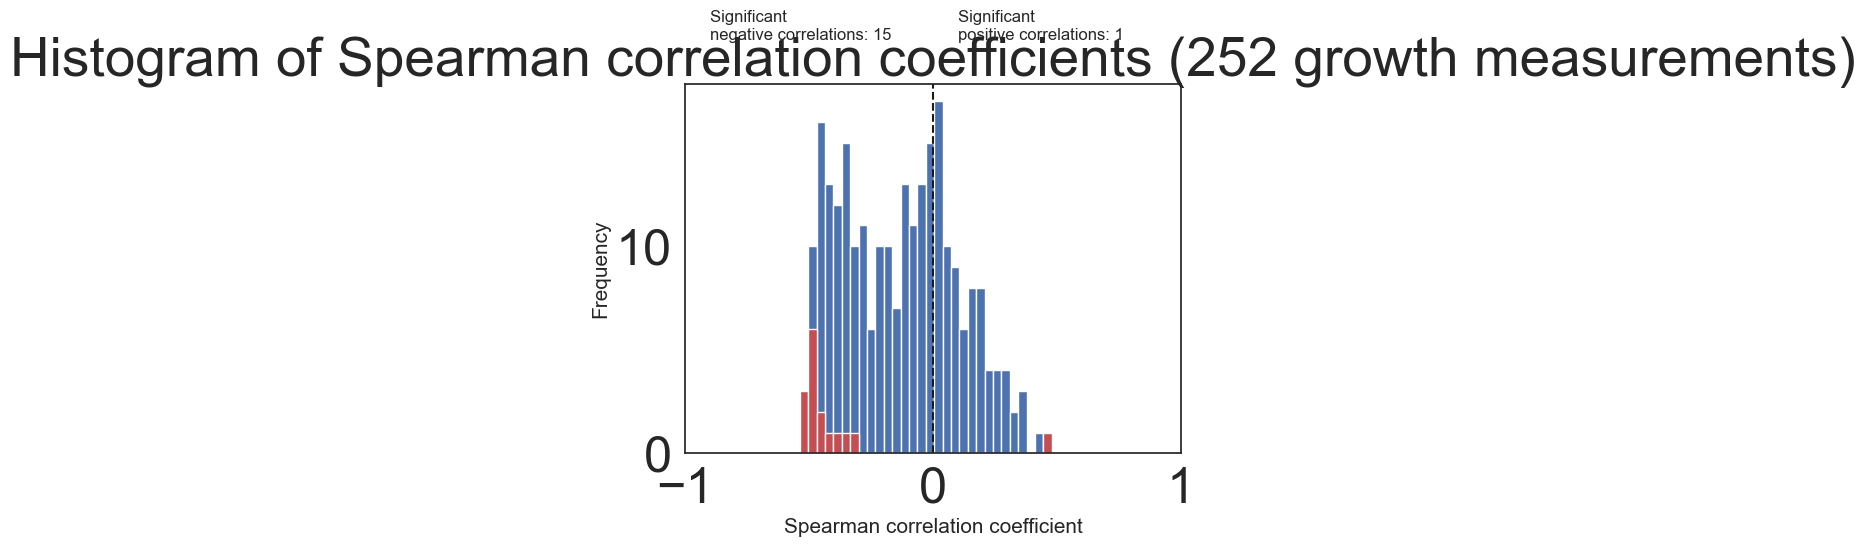

In [21]:
#corrs["Pearson"] histogram
plt.hist(corrs["Spearman"], bins=30)
plt.xlabel("Spearman correlation coefficient", fontsize=15)
plt.ylabel("Frequency", fontsize=15)
plt.title("Histogram of Spearman correlation coefficients (252 growth measurements)")
#x axis from -1 to 1
plt.xlim(-1,1)
#vertical line at 0
plt.axvline(x=0, color='k', linestyle='--')
#write number of negative and positive correlations
plt.text(-0.9, 20, 'Significant \nnegative correlations: ' + str(len(sig_corrs[sig_corrs['Spearman']<0])), fontsize=12)
plt.text(0.1, 20, 'Significant \npositive correlations: ' + str(len(sig_corrs[sig_corrs['Spearman']>0])), fontsize=12)
#overlay red histogram of sig_corrs
plt.hist(sig_corrs["Spearman"], bins=30, color='r')



In [22]:
corrs

,Pearson,Spearman,Pearson p-value,Spearman p-value,T_test,ANOVA_pvalue,phenotype,bonferroni
smgrowth.LiCl.10.mM,-0.138413,-0.366489,0.098035,0.000006,NaN,NaN,smgrowth.LiCl.10.mM,0.001575
wb.Galactose2.Efficiency,0.355415,0.478805,0.001887,0.000016,NaN,NaN,wb.Galactose2.Efficiency,0.004017
smgrowth.MgCl2.0.2.M,-0.187114,-0.388758,0.045245,0.000018,NaN,NaN,smgrowth.MgCl2.0.2.M,0.004431
2percent_Glycerol_2.5g.l_NaAc,-0.503663,-0.536508,0.000089,0.000024,NaN,NaN,2percent_Glycerol_2.5g.l_NaAc,0.006097
wb.Maltose2.Efficiency,-0.516134,-0.463259,0.000003,0.000032,NaN,NaN,wb.Maltose2.Efficiency,0.008148
...,...,...,...,...,...,...,...,...
wb.Arabinose2.lag,0.009064,-0.004444,0.938906,0.970027,NaN,NaN,wb.Arabinose2.lag,1.000000
wb.Arabinose2.Rate,-0.221443,-0.002994,0.057946,0.979799,NaN,NaN,wb.Arabinose2.Rate,1.000000
wb.HqCl215.uM.Efficiency,-0.188302,0.002061,0.108128,0.986093,NaN,NaN,wb.HqCl215.uM.Efficiency,1.000000
wb.Hydroxyurea8mg.ml.Efficiency,0.254224,-0.001634,0.028835,0.988975,NaN,NaN,wb.Hydroxyurea8mg.ml.Efficiency,1.000000


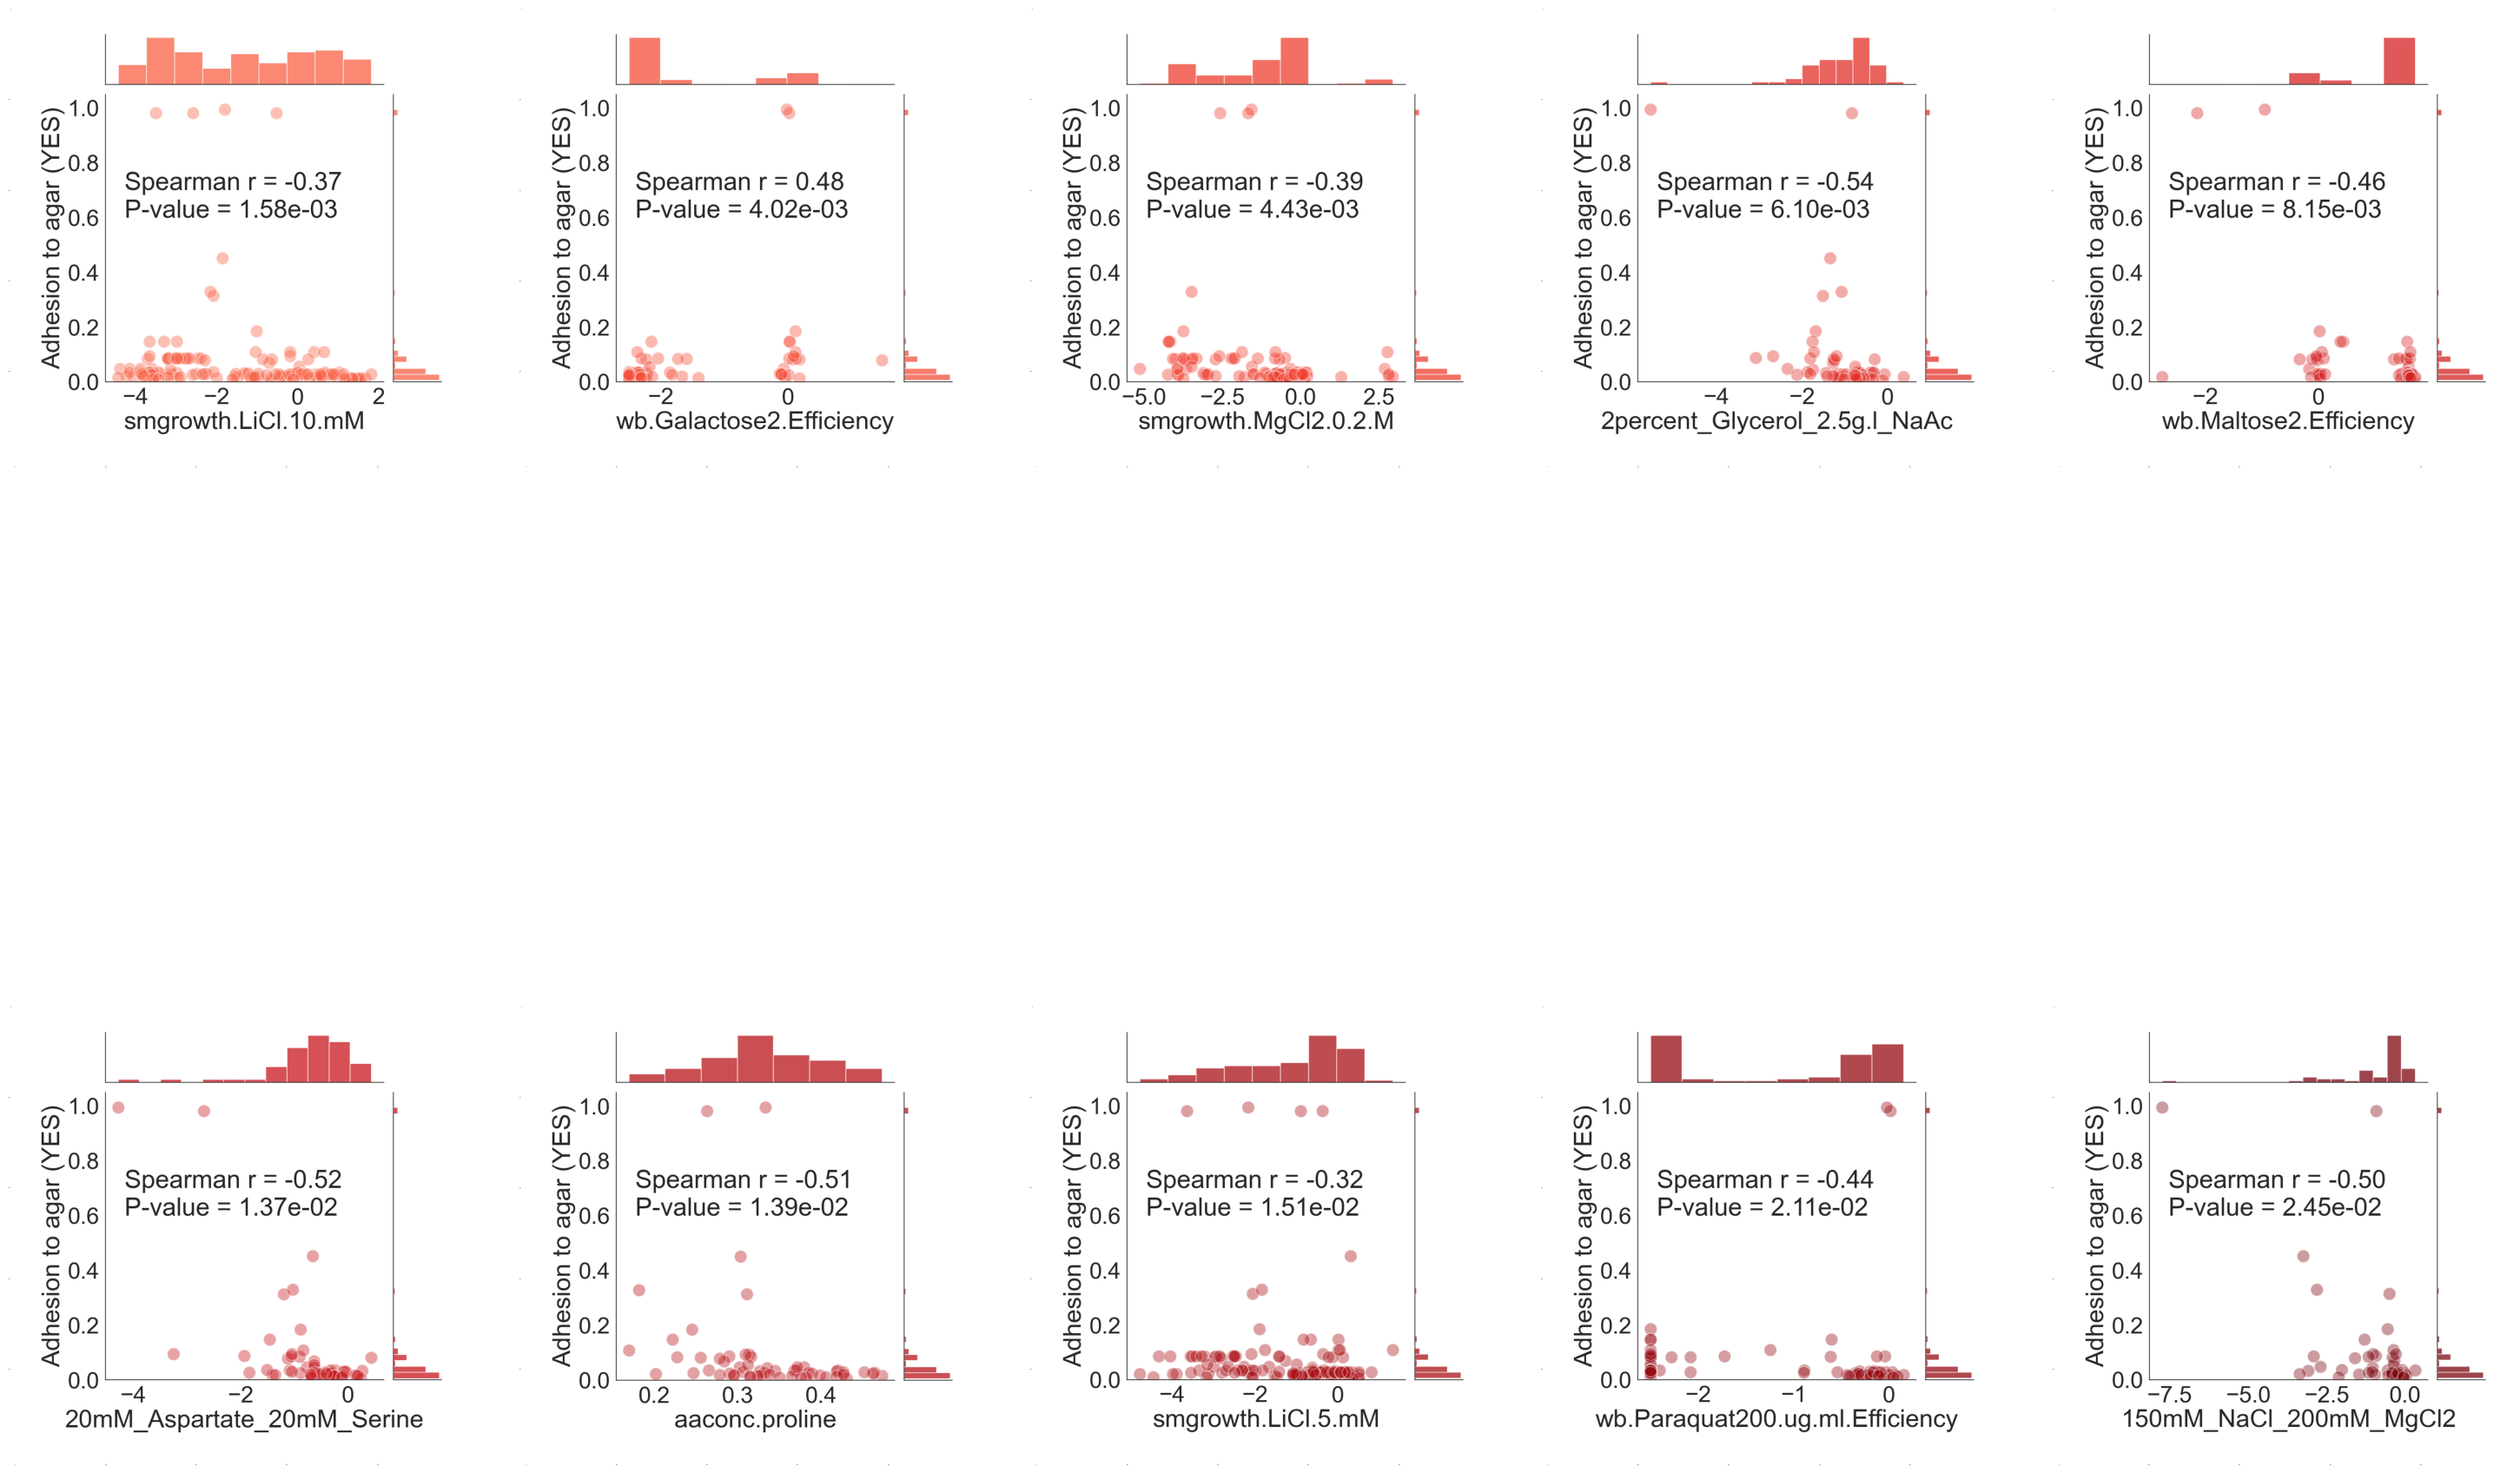

In [23]:
colors = sns.color_palette("Reds", 20)

#put 5 of these in a row by saving them as images and the using the image function in matplotlib
for i,j,col in zip(range(10),corrs.head(10).index.values,colors[10:]):
    
    #large glyph with alpha transparency large ticks
    
    sns.jointplot(data=data, x=j, y='Adhesion to agar (YES)', color=col, height=10, s= 400,alpha = 0.4)
    
    #no axis labels
    plt.ylabel('')
    plt.xlabel('')
   
    #remove grid
    #add p value
    #ticks larger font
    sns.set(font_scale=3.3)
  
    #ylim is 1
    plt.ylim(0,1.05)

    sns.set_style("white", {'axes.grid' : False})
    sns.despine()
    

#print corr coef
#   subset of dataset of thes two columns
    subset = data[[j, 'Adhesion to agar (YES)']]
    #drop inf
    subset = subset.replace([np.inf, -np.inf], np.nan)
    #remove nans
    subset = subset.dropna()
    plt.text(-400,0.7,'Spearman r = {:.2f}'.format(corrs.loc[j]['Spearman']),fontsize=40)
    plt.text(-400,0.6,'P-value = {:.2e}'.format(corrs.loc[j]['bonferroni']),fontsize=40)
    plt.savefig('jointplot{}.png'.format(i))
    plt.close()
    
for i,j in zip(range(10),corrs.head(10).index.values):
    #load them and arange in one big plot
    
    plt.subplot(2,5,i+1)
    #read big figure
    plt.imshow(plt.imread('jointplot{}.png'.format(i)))
    #increase size
    plt.gcf().set_size_inches(30,30)
    plt.axis('off')
    plt.axis('on')
   
    #remove ticks
    plt.tick_params(labelsize=0)
    #remove frame
    plt.gca().spines['top'].set_visible(False)
    plt.gca().spines['right'].set_visible(False)
    plt.gca().spines['bottom'].set_visible(False)
    plt.gca().spines['left'].set_visible(False)
    #remove the ticks of the outer frame
    plt.gca().tick_params(axis='both', which='both', length=0)
#tight layout
plt.tight_layout()

In [41]:
corrs = correlation(data,"Washing (YES)")
corrs = corrs.sort_values(by=['Spearman p-value'])
#corrs remove nan from spearman and then create column called fdr
corrs = corrs.dropna(subset=['Spearman p-value'])
import statsmodels.stats.multitest as smm
corrs['fdr'] = smm.multipletests(corrs['Spearman p-value'], method='bonferroni')[1]
corrs.head(20)

/Users/bencekover/opt/anaconda3/lib/python3.9/site-packages/scipy/stats/stats.py:4023: PearsonRConstantInputWarning: An input array is constant; the correlation coefficient is not defined.
  warnings.warn(PearsonRConstantInputWarning())
/Users/bencekover/opt/anaconda3/lib/python3.9/site-packages/scipy/stats/stats.py:4484: SpearmanRConstantInputWarning: An input array is constant; the correlation coefficient is not defined.
  warnings.warn(SpearmanRConstantInputWarning())


,Pearson,Spearman,Pearson p-value,Spearman p-value,T_test,ANOVA_pvalue,phenotype,fdr
Floc (EMM),0.493604,0.400620,4.402871e-11,1.829517e-07,NaN,NaN,Floc (EMM),0.000056
shape2.KL.Predicted.Tshape,0.084219,0.371585,2.912141e-01,1.418838e-06,NaN,NaN,shape2.KL.Predicted.Tshape,0.000433
smgrowth.LiCl.10.mM,-0.138413,-0.366489,9.803514e-02,6.250283e-06,NaN,NaN,smgrowth.LiCl.10.mM,0.001906
2mM_H2O2,-0.749720,-0.551082,4.506827e-11,1.300793e-05,NaN,NaN,2mM_H2O2,0.003967
wb.Galactose2.Efficiency,0.355415,0.478805,1.886937e-03,1.594024e-05,NaN,NaN,wb.Galactose2.Efficiency,0.004862
smgrowth.MgCl2.0.2.M,-0.187114,-0.388758,4.524470e-02,1.758247e-05,NaN,NaN,smgrowth.MgCl2.0.2.M,0.005363
2percent_Glycerol_2.5g.l_NaAc,-0.503663,-0.536508,8.858807e-05,2.419355e-05,NaN,NaN,2percent_Glycerol_2.5g.l_NaAc,0.007379
wb.Maltose2.Efficiency,-0.516134,-0.463259,2.516257e-06,3.233481e-05,NaN,NaN,wb.Maltose2.Efficiency,0.009862
3mM_H2O2,-0.527899,-0.523016,3.444424e-05,4.190843e-05,NaN,NaN,3mM_H2O2,0.012782
20mM_Aspartate_20mM_Serine,-0.661474,-0.516450,3.844794e-08,5.429972e-05,NaN,NaN,20mM_Aspartate_20mM_Serine,0.016561


In [42]:
corrs = correlation(data,"substrate")
#sort by ANOVA_pvalue	
corrs = corrs.sort_values(by=['ANOVA_pvalue'])
corrs.head(50)



/Users/bencekover/opt/anaconda3/lib/python3.9/site-packages/scipy/stats/stats.py:3650: F_onewayConstantInputWarning: Each of the input arrays is constant;the F statistic is not defined or infinite
  warnings.warn(F_onewayConstantInputWarning())


,Pearson,Spearman,Pearson p-value,Spearman p-value,T_test,ANOVA_pvalue,phenotype
aaconc.tryptophan,NaN,NaN,NaN,NaN,NaN,3.001054e-11,aaconc.tryptophan
MCL cluster,NaN,NaN,NaN,NaN,NaN,7.901490e-09,MCL cluster
smgrowth.glycerol.2percent,NaN,NaN,NaN,NaN,NaN,1.493737e-06,smgrowth.glycerol.2percent
smgrowth.cycloheximide.100.ng.ml,NaN,NaN,NaN,NaN,NaN,2.612256e-05,smgrowth.cycloheximide.100.ng.ml
smgrowth.Brefeldin.A.120.uM,NaN,NaN,NaN,NaN,NaN,3.305016e-05,smgrowth.Brefeldin.A.120.uM
wb.Heat40.C.Rate,NaN,NaN,NaN,NaN,NaN,5.088511e-05,wb.Heat40.C.Rate
wb.Ethanol.growth.2.lag,NaN,NaN,NaN,NaN,NaN,5.229697e-05,wb.Ethanol.growth.2.lag
wb.MMS0.0015.Rate,NaN,NaN,NaN,NaN,NaN,7.519201e-05,wb.MMS0.0015.Rate
lmgrowth.emm2.max.slope.time,NaN,NaN,NaN,NaN,NaN,9.609043e-05,lmgrowth.emm2.max.slope.time
smgrowth.MgCl2.0.2.M,NaN,NaN,NaN,NaN,NaN,3.163532e-04,smgrowth.MgCl2.0.2.M


/Users/bencekover/opt/anaconda3/lib/python3.9/site-packages/seaborn/axisgrid.py:2203: UserWarning: The marginal plotting function has changed to `histplot`, which does not accept the following argument(s): rug.
  warnings.warn(msg, UserWarning)
/var/folders/mb/vdj4y7t13zd3tzlk99b8ycd40000gn/T/ipykernel_68254/40071504.py:21: UserWarning: Tight layout not applied. tight_layout cannot make axes width small enough to accommodate all axes decorations
  plt.tight_layout()


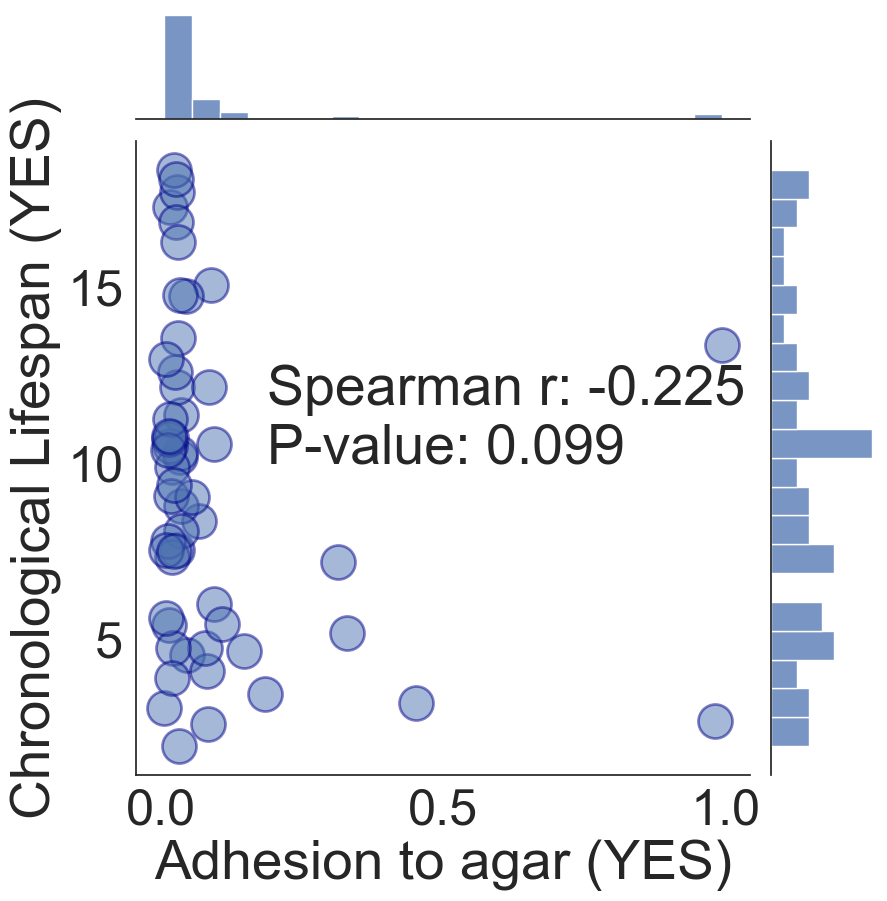

In [91]:
#large fig
#change Lifespan to Chronological Lifespan (YES)


sns.jointplot(x="Adhesion to agar (YES)", y="Chronological Lifespan (YES)", data=data, color="b",  alpha=0.5, marker='o', edgecolor='darkblue', marginal_kws=dict(bins=20, rug=True), s=600, height=10)

#change Lifespan to Chronological Lifespan (YES)
plt.xlabel('Adhesion to agar (YES)')
plt.ylabel('Chronological Lifespan (YES)')
#print spearman correlation coefficient and p value on the plot
#create subset df without nans in these two columns
subset = data[['Adhesion to agar (YES)', 'Chronological Lifespan (YES)']]
subset = subset.replace([np.inf, -np.inf], np.nan)
subset = subset.dropna()
#ticks more detailed. 10 ticks between min and max + 10% of each axis


#round to 3 digits
plt.text(-40, 10, 'Spearman r: ' + str(round(st.spearmanr(subset['Adhesion to agar (YES)'], subset['Chronological Lifespan (YES)'])[0],3)) + '\n' + 'P-value: ' + str(round(st.spearmanr(subset['Adhesion to agar (YES)'], subset['Chronological Lifespan (YES)'])[1],3)), fontsize=40)
#tight
plt.tight_layout()
    

In [ ]:
#Repeat for folamentous
data.reset_index(inplace=True,drop=True)
#loop through all columns and calculate correlation coefficient and pval
for i in range(1,len(data.columns)-1):
    
    #phentype with nan removed
    phenotype = data.iloc[:,i].dropna()
    #ratios with indices of phenotype 
    ratios = data['filamentous'].iloc[phenotype.index]
    #create a new df with phenotype, corr_coef, pval
    corr_coef, pval = st.spearmanr(phenotype,ratios)
    new_df = pd.DataFrame({'phenotype':[data.columns[i]],'corr_coef':[corr_coef],'pval':[pval]})
    #merge it with the empty df
    if i == 1:
        corr_df = new_df
    else:
        corr_df = corr_df.append(new_df,ignore_index=True)
#calculate fdr corrected pval using statsmodels
from statsmodels.stats.multitest import multipletests
#remove nan
#corr_df = corr_df[corr_df['pval'].notna()]
#remove first entry
#reset index
corr_df = corr_df.sort_values(by='pval')
corr_df = corr_df.reset_index(drop=True)
corr_df = corr_df.iloc[2:]
corr_df['fdr_pval'] = multipletests(corr_df['pval'], method='fdr_bh')[1]
#sort based on pval
corr_df = corr_df.sort_values(by='pval')
corr_df = corr_df.reset_index(drop=True)
#plot ratio vs shape2.length
corr_df

/var/folders/mb/vdj4y7t13zd3tzlk99b8ycd40000gn/T/ipykernel_5174/3703409537.py:17: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  corr_df = corr_df.append(new_df,ignore_index=True)
/Users/bencekover/opt/anaconda3/lib/python3.9/site-packages/scipy/stats/stats.py:4484: SpearmanRConstantInputWarning: An input array is constant; the correlation coefficient is not defined.
  warnings.warn(SpearmanRConstantInputWarning())


,phenotype,corr_coef,pval,fdr_pval
0,shape1.facs.percent2C,-0.527024,0.000030,NaN
1,shape1.facs.percent2to4C,0.524270,0.000034,NaN
2,aaconc.proline,-0.475319,0.000245,NaN
3,misc.flocculation,0.487869,0.000377,NaN
4,shape2.KL.Predicted.Tshape,0.443158,0.000556,NaN
...,...,...,...,...
218,wb.Nostress.lag,0.006432,0.970302,NaN
219,wb.MMS0.0015.lag,0.006432,0.970302,NaN
220,smgrowth.H2O2.3.mM,0.002886,0.983156,NaN
221,wb.Arsenite0.2mM.lag,0.000000,1.000000,NaN


In [ ]:
#Repeat for folamentous
data.reset_index(inplace=True,drop=True)
#loop through all columns and calculate correlation coefficient and pval
for i in range(0,len(data.columns)):
    
    #phentype with nan removed
    phenotype = data.iloc[:,i].dropna()
    #drop na in column misc.flocculation
    phenotype = phenotype[data['misc.flocculation'].notna()]
    #drop na in filamentous
    phenotype = phenotype[data['filamentous'].notna()]
    #drop na in ratio
    phenotype = phenotype[data['ratio'].notna()]

    #ratios with indices of phenotype 
    ratios = data['misc.flocculation'].iloc[phenotype.index]
    #create a new df with phenotype, corr_coef, pval
    corr_coef, pval = st.spearmanr(phenotype,ratios)
    new_df = pd.DataFrame({'phenotype':[data.columns[i]],'corr_coef':[corr_coef],'pval':[pval]})
    #merge it with the empty df
    if i == 1:
        corr_df = new_df
    else:
        corr_df = corr_df.append(new_df,ignore_index=True)
#calculate fdr corrected pval using statsmodels
from statsmodels.stats.multitest import multipletests
#remove nan
#corr_df = corr_df[corr_df['pval'].notna()]
#remove first entry
#reset index
corr_df = corr_df.sort_values(by='pval')
corr_df = corr_df.reset_index(drop=True)
corr_df = corr_df.iloc[2:]
corr_df['fdr_pval'] = multipletests(corr_df['pval'], method='fdr_bh')[1]
#sort based on pval
corr_df = corr_df.sort_values(by='pval')
corr_df = corr_df.reset_index(drop=True)
#plot ratio vs shape2.length
corr_df

/var/folders/mb/vdj4y7t13zd3tzlk99b8ycd40000gn/T/ipykernel_5174/2139008986.py:24: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  corr_df = corr_df.append(new_df,ignore_index=True)
/Users/bencekover/opt/anaconda3/lib/python3.9/site-packages/scipy/stats/stats.py:4484: SpearmanRConstantInputWarning: An input array is constant; the correlation coefficient is not defined.
  warnings.warn(SpearmanRConstantInputWarning())


,phenotype,corr_coef,pval,fdr_pval
0,shape1.facs.percent2to4C,0.557835,0.000046,NaN
1,filamentous,0.487869,0.000377,NaN
2,shape1.length.CoV,0.448097,0.001585,NaN
3,shape2.KL.Predicted.Banana,0.420568,0.002622,NaN
4,shape1.length.stdev,0.423620,0.003006,NaN
...,...,...,...,...
219,wb.MMS0.0015.Efficiency,0.008233,0.961991,NaN
220,wb.KCl1.45M.Rate,0.007938,0.963352,NaN
221,wb.Nostress.Efficiency,0.005485,0.974671,NaN
222,shape2.KL.Predicted.Orb,-0.001576,0.991424,NaN


# There are various ways to validate our dataset against old measurements. One is to compare pixel intensity on our "before pictures" vs. growth on EMM as measured by Jeffares et al. 

0.014373571806581317
0.0006083944890974455


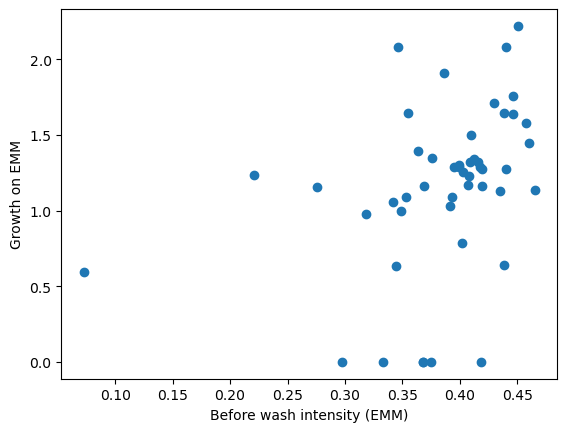

In [ ]:
#plot between before_Wash and smgrowth.EMM  
plt.scatter(data['before_wash'], data['smgrowth.EMM'])
#print a p_value
import scipy.stats as st
#eep only values than are not NaN in both arrays
mask = ~np.isnan(data['before_wash']) & ~np.isnan(data['smgrowth.EMM'])
x=data['before_wash'][mask]
y=data['smgrowth.EMM'][mask]
#label axes
plt.xlabel('Before wash intensity (EMM)')
plt.ylabel('Growth on EMM')


print(st.pearsonr(x,y)[1])
print(st.spearmanr(x,y)[1])


Text(0.5, 1.0, 'Filamentous growth vs Adhesion')

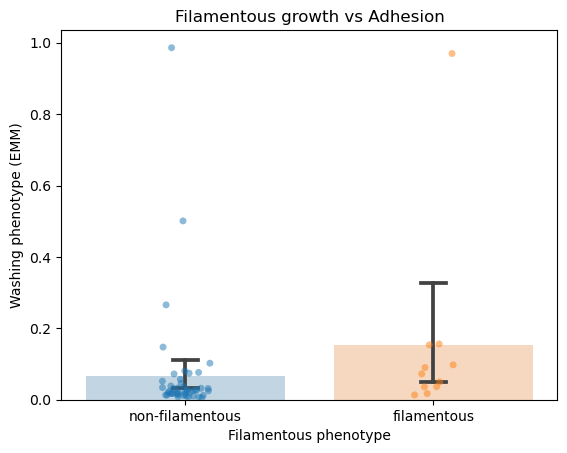

In [ ]:
#plot ratio vs filamentous as barplot and overlay scatter using sns. make error bars with caps

sns.barplot(x='filamentous',y='ratio',data=data, alpha=0.3,capsize=0.1)
sns.stripplot(x='filamentous',y='ratio',data=data, alpha=0.5, jitter=True)
#rename 0 and 1 to filamentous and non-filamentous
plt.xticks([0,1],['non-filamentous','filamentous'])
plt.xlabel('Filamentous phenotype')
plt.ylabel('Washing phenotype (EMM)')
plt.title('Filamentous growth vs Adhesion')

Text(0.5, 1.0, 'Filamentous growth vs Adhesion')

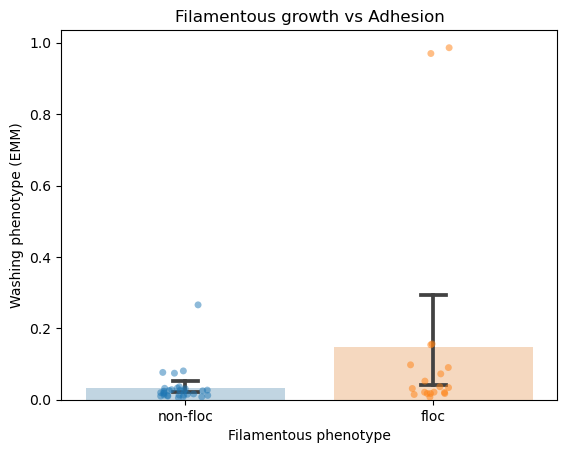

In [ ]:
sns.barplot(x='misc.flocculation',y='ratio',data=data, alpha=0.3,capsize=0.1)
sns.stripplot(x='misc.flocculation',y='ratio',data=data, alpha=0.5, jitter=True)
#rename 0 and 1 to filamentous and non-filamentous
plt.xticks([0,1],['non-floc','floc'])
plt.xlabel('Filamentous phenotype')
plt.ylabel('Washing phenotype (EMM)')
plt.title('Filamentous growth vs Adhesion')

SpearmanrResult(correlation=-0.17171717171717168, pvalue=0.2143919303368109)

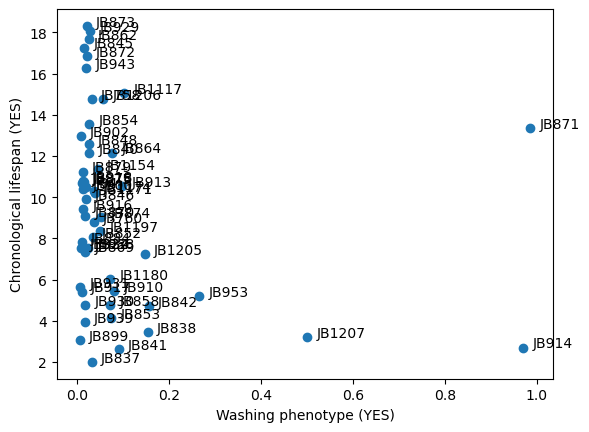

In [ ]:
#import Livs phenotype data /Users/bencekover/Library/CloudStorage/OneDrive-UniversityCollegeLondon/MSci Bahler lab/S.-Pombe-biofilm/internal data/Liv_data_mean.csv
liv_data = pd.read_csv(root + 'internal data/Liv_data_mean.csv')
#merge washing and liv_data on Sample = strain
liv_data = liv_data.merge(washing_yes, left_on='Sample', right_on='strain')
#scatter plot of Lifespan and ratio using matplotlib
plt.scatter(liv_data['ratio'],liv_data['Lifespan'])
#label with strain
for i, txt in enumerate(liv_data['Sample']):
    plt.annotate(txt, (liv_data['ratio'][i]+0.02, liv_data['Lifespan'][i]))
#label axes
plt.xlabel('Washing phenotype (YES)')
plt.ylabel('Chronological lifespan (YES)')
#give me correlation coefficient and p value
#remove nan entries
liv_data = liv_data[liv_data['ratio'].notna()]
liv_data = liv_data[liv_data['Lifespan'].notna()]
#calculate correlation coefficient
np.corrcoef(liv_data['ratio'],liv_data['Lifespan'])
#calculate p value from spearman rank correlation
from scipy.stats import spearmanr
spearmanr(liv_data['ratio'],liv_data['Lifespan'])




In [ ]:
#see if there is a sighnificant correlation between ratio and any of the other columns, except Sample and the last 5 columns. Return results in df
def get_correlation(df,row_of_interest):
    #initialise df
    results = pd.DataFrame(columns=['measurement','n_measurement','correlation','p_value'])
    #loop through columns
    temp_data_ = df[df['ratio'].notna()]
    for col in df.columns:
        #if the column is numeric
        if df[col].dtype == 'float64':

            if col != 'Sample' and  col != 'strain':
                #remove nan entries
                #keep subset where entries in column "ratio" are not nan
                
   
                temp_data = temp_data_[col].dropna()
                temp_ratio = temp_data_[row_of_interest][temp_data.index]
                #calculate correlation coefficient
                
                #calculate p value
                from scipy.stats import spearmanr
                coef, p = spearmanr(temp_ratio, temp_data)
                #save results
                residuals = temp_ratio - coef*temp_data
                temp_results = pd.DataFrame({'measurement': [col],'n_measurement':[len(temp_data)], 'correlation': [coef], 'p_value': [p]})
                results = pd.concat([results, temp_results], ignore_index=True)
              
                
    #correct the p_values by simple bonferroni correction
    results['p_value_corrected'] = results['p_value']*len(results)
    #sort the results by score
    results = results.sort_values(by='p_value_corrected', ascending=True)
    return results

#see if there is a sighnificant correlation between ratio and any of the other columns, except Sample and the last 5 columns. Return results in df
df = get_correlation(liv_data,"ratio").head(50)
#RESET INDEX
df = df.reset_index(drop=True)


Text(0, 0.5, 'Washing phenotype (EMM)')

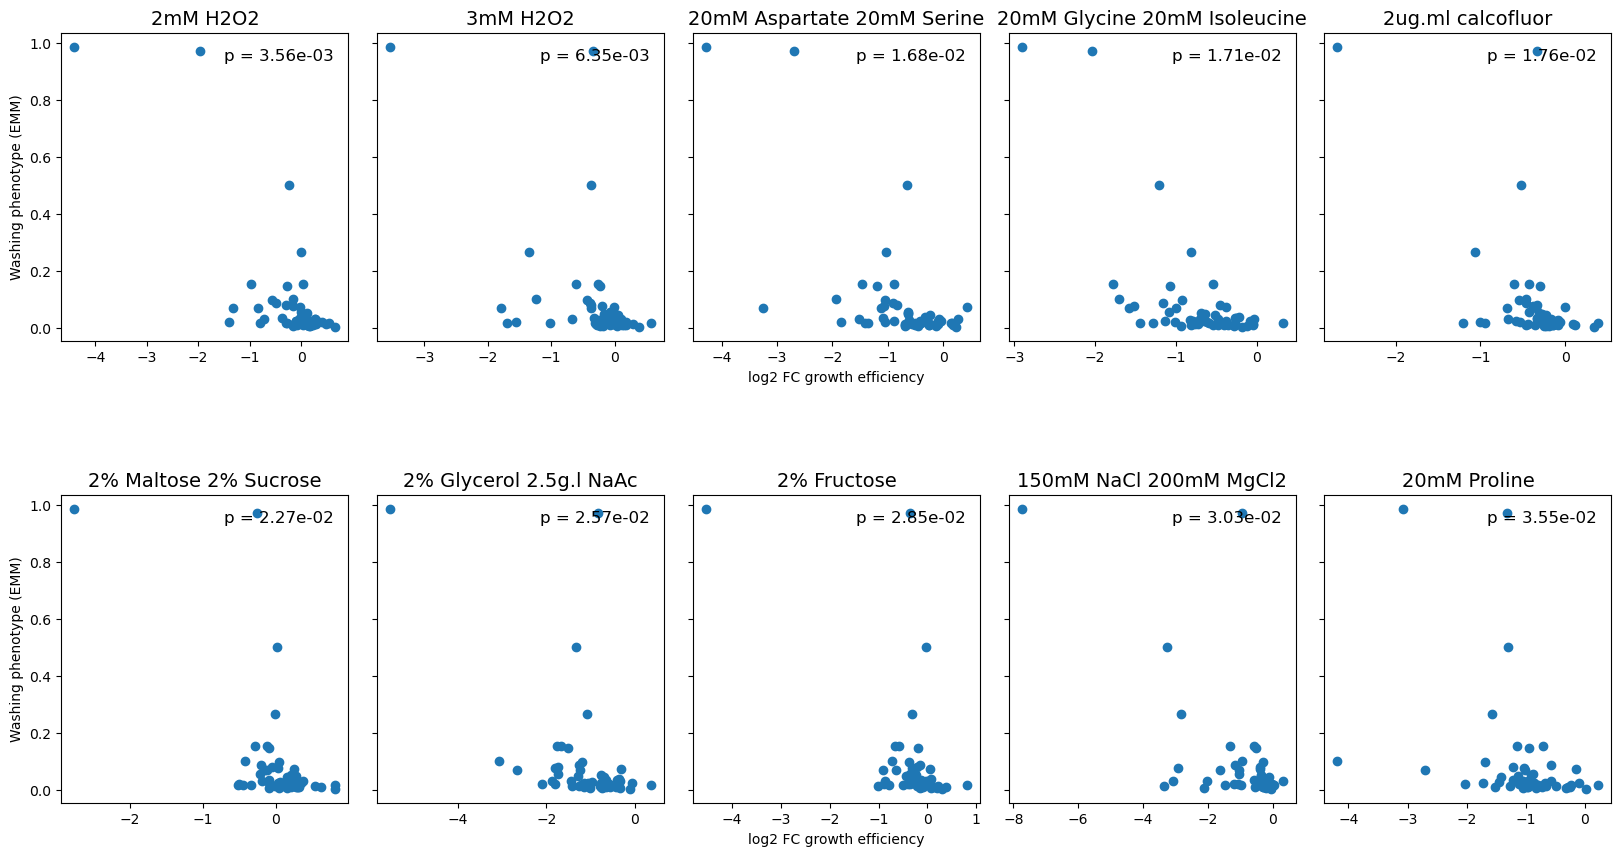

In [ ]:
#create a large 2x5 plot of the 10 most significant correlations, but not the first one
plot_df = df.iloc[1:11]
plot_df = plot_df.reset_index(drop=True)
fig, axs = plt.subplots(2, 5, figsize=(20, 10))
fig.subplots_adjust(hspace = .5, wspace= 0.1)
axs = axs.ravel()
for i in range(10):
      #get the column name
      col = plot_df.iloc[i]['measurement']
      #get the data
      temp_data = liv_data[col].dropna()
      temp_ratio = liv_data['ratio'][temp_data.index]
      #plot
      axs[i].scatter(temp_data,temp_ratio)
      

      #remove y axis label if i is not 0,5,10
      if i not in [0,5]:
            axs[i].set_yticklabels([])
      #x lable large font
      #make col into a string where  is replaced by space
      col = col.replace('_',' ')
      #change percent to %
      col = col.replace('percent','%')
      #make col the title and x_label is log2 FC growth efficiency
      #title
      axs[i].set_title(col,fontsize=14)
      #x label only for 2, 7, 12
      if i in [2,7]:
            axs[i].set_xlabel('log2 FC growth efficiency')


      #p val corrected and in scinetific ntoation on top right corner of each plot
      axs[i].text(0.95, 0.95, 'p = {:.2e}'.format(plot_df.iloc[i]['p_value_corrected']), transform=axs[i].transAxes, fontsize=12,
            verticalalignment='top', horizontalalignment='right') 

     
#add y axis label
axs[0].set_ylabel('Washing phenotype (EMM)')
axs[5].set_ylabel('Washing phenotype (EMM)')


      


SpearmanrResult(correlation=-0.38791690489803693, pvalue=0.003751611686689343)

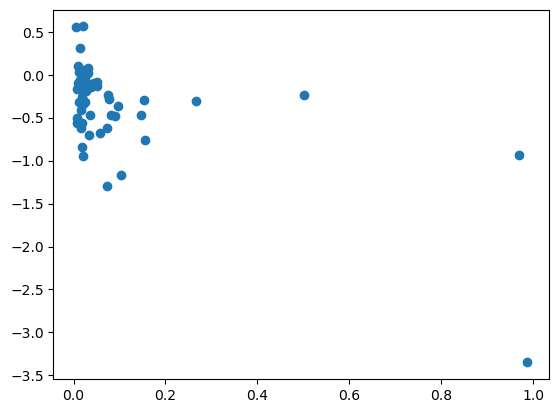

In [ ]:
fig, ax = plt.subplots()
ax.scatter(liv_data['ratio'],liv_data['EMM'])
#show correlation
from scipy.stats import spearmanr
spearmanr(liv_data['ratio'],liv_data['EMM'])

In [ ]:
#in liv data, for each column calculate its residuals with EMM
liv_resid_data = liv_data.copy()
for col in liv_data.columns:
      if col != 'Sample' and  col != 'strain':
            #remove nan entries
            #keep subset where entries in column "ratio" are not nan
            temp_data = liv_data[col].dropna()
            emm_data = liv_data['EMM'][temp_data.index]
            #calculate slope
            slope = np.polyfit(emm_data, temp_data, 1)[0]

            #intercept
            intercept = np.polyfit(emm_data, temp_data, 1)[1]
            #calculate residuals
            residuals = temp_data - (emm_data*slope + intercept)
            #save results
            liv_resid_data[col] = residuals
df = get_correlation(liv_resid_data,"ratio").head(10)
df

,measurement,n_measurement,correlation,p_value,p_value_corrected
78,ratio,54,1.000000,0.000000,0.000000
63,EMM,54,-0.544533,0.000021,0.001639
15,10ug.ml_calcofluor_10mM_HU,54,-0.444483,0.000759,0.059993
41,2percent_Fructose,54,-0.439756,0.000877,0.069301
24,1mM_TBH,54,-0.438917,0.000900,0.071082
39,2mM_H2O2,54,-0.416505,0.001732,0.136812
23,150mM_NaCl_200mM_MgCl2,54,-0.394168,0.003186,0.251714
21,150mM_NaCl_0.0025percent_MMS,54,-0.360930,0.007335,0.579427
20,150mM_NaCl,54,-0.353154,0.008808,0.695841
50,2percent_Maltose_150mM_NaCl,54,-0.341872,0.011400,0.900601


Text(0.05, -4, 'spearman r = -0.16, p = 2.59e-01')

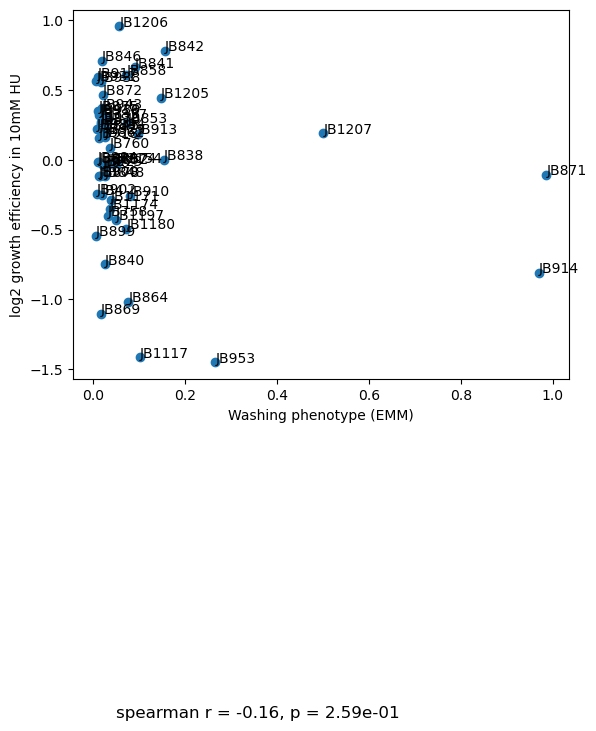

In [ ]:
#in liv data, for each column calculate its residuals with EMM
#make plot of ratio vs 10mM_HU
fig, ax = plt.subplots()
ax.scatter(liv_data['ratio'],liv_resid_data['10mM_HU'])
#label with strain
for i, txt in enumerate(liv_data['Sample']):
      ax.annotate(txt, (liv_data['ratio'][i], liv_resid_data['10mM_HU'][i]))
#label axes
ax.set_xlabel('Washing phenotype (EMM)')
ax.set_ylabel('log2 growth efficiency in 10mM HU')
#title


#calculate spearman corr coef and p value
from scipy.stats import spearmanr
#print it at 0.1, -3 on the figure. Only the first 2 significant digits and p value in scientific notation
corr = spearmanr(liv_data['ratio'],liv_resid_data['10mM_HU'])
ax.text(0.05, -4, 'spearman r = {:.2f}, p = {:.2e}'.format(corr[0], corr[1]), fontsize=12)



In [ ]:
#measure pairwise correlations between all residuals lists. Return the measurement name of hgihly significant pairs
def get_pairwise_correlation(df):
    #initialise df
    #reset index of df
    df = df.reset_index(drop=True)
    results = pd.DataFrame(columns=['measurement1','measurement2','correlation','p_value'])
    #loop through columns
    for i in range(len(df)):
        for j in range(i+1,len(df)):
            #if the column is numeric
            if df['residuals'][i].dtype == 'float64':
                #remove nan entries
                temp_data1 = df['residuals'][i].dropna()
                temp_data2 = df['residuals'][j].dropna()
                #calculate correlation coefficient
                correlation = np.corrcoef(temp_data1,temp_data2)[0][1]
                #calculate p value
                from scipy.stats import pearsonr
                p_value = pearsonr(temp_data1,temp_data2)[1]
                #save results
                temp_results = pd.DataFrame({'measurement1': [df['measurement'][i]],'measurement2': [df['measurement'][j]],'correlation': correlation, 'p_value': p_value})
                results = pd.concat([results, temp_results], ignore_index=True)
    #correct the p_values by simple bonferroni correction
    results['p_value_corrected'] = results['p_value']*len(results)
    #sort the results by score
    results = results.sort_values(by='p_value_corrected', ascending=True)
    return results
pw_corr = get_pairwise_correlation(df)

KeyError: 'residuals'

In [ ]:
#Looking at sample origin

In [ ]:
%load_ext watermark
%watermark -v -p numpy,pandas,scipy,bokeh,iqplot,bebi103,jupyterlab